In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['font.size']=18
rcParams['figure.figsize'] = (12.,8.)

In [3]:
rawpath = '/data/ebex/ld2012/flight/raw/acs_v0-0/'

In [4]:
import sys
sys.path.append('/home/gjones/')

In [5]:
import leap
from leap.lib.xsc import loading,leveling

/home/gjones/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [6]:
import pandas as pd
import joblib
import time

In [7]:
xsc_df = pd.DataFrame.from_records(np.load('/home/gjones/xsc_data.npz')['recs'][()],index='index')

In [8]:
xsc_df.shape

(41262, 44)

In [9]:
xsc_df.lat_lon_valid.value_counts()

True     30291
False    10971
Name: lat_lon_valid, dtype: int64

In [106]:

xsc_df.filename.iloc[1000
                ]

'2012-12-30--03-14-16--640.fits'

In [10]:
list(xsc_df)

['alt',
 'az_guess',
 'cleanly_matched',
 'corner_lats',
 'corner_lats_deg',
 'corner_lons',
 'corner_lons_deg',
 'day_name',
 'dec',
 'dec_err',
 'dec_error',
 'dec_guess',
 'dirfile_name',
 'distance_from_sun',
 'el_guess',
 'end_index',
 'filename',
 'filename_base',
 'imlat',
 'imlon',
 'iplatescale',
 'is_at_float',
 'lat',
 'lat_deg',
 'lat_lon_valid',
 'lon',
 'lon_deg',
 'lst',
 'num_matched',
 'part',
 'projection_conversion',
 'projection_conversion_x',
 'ra',
 'ra_err',
 'ra_error',
 'ra_guess',
 'roll',
 'roll_error',
 'roll_guess',
 'start_index',
 'timestamp',
 'which',
 'xfilename',
 'xfilename_base']

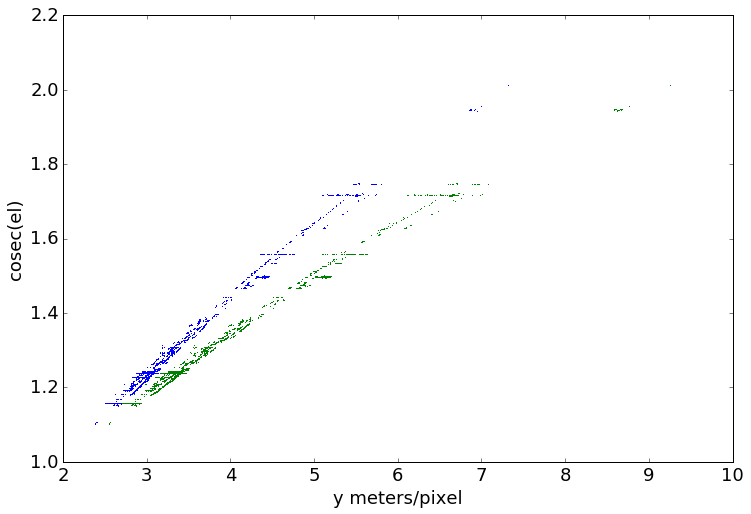

In [11]:
dd = xsc_df[(xsc_df.lat !=0) & (xsc_df.el_guess >0.5) &(xsc_df.alt>30000) & (xsc_df.alt < 40000) & (xsc_df.dec_err < 0.02)]
plot(dd.projection_conversion,1/np.sin(dd.el_guess),',')
dd2 = dd[dd.which==0]
plot(dd2.projection_conversion,1/np.sin(dd2.el_guess),',')
xlabel('y meters/pixel')
ylabel('cosec(el)')

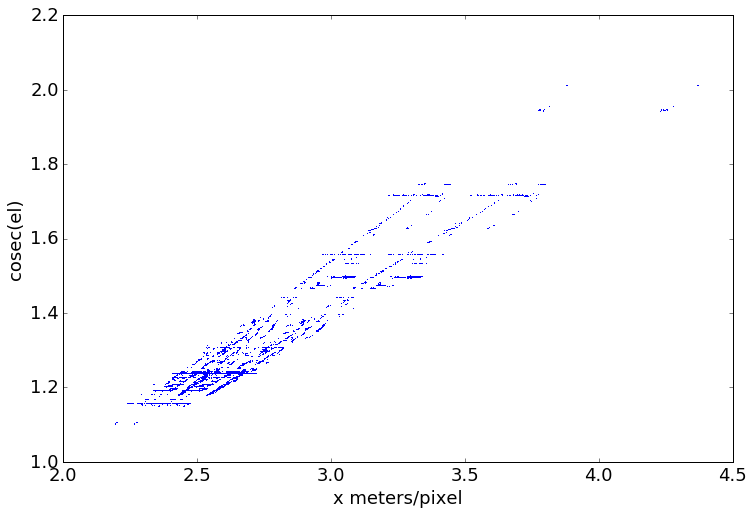

In [12]:
#dd = xsc_df[(xsc_df.lat !=0) & (xsc_df.el_guess >0.5)]
plot(dd.projection_conversion_x,1/np.sin(dd.el_guess),',')
xlabel('x meters/pixel')
ylabel('cosec(el)')

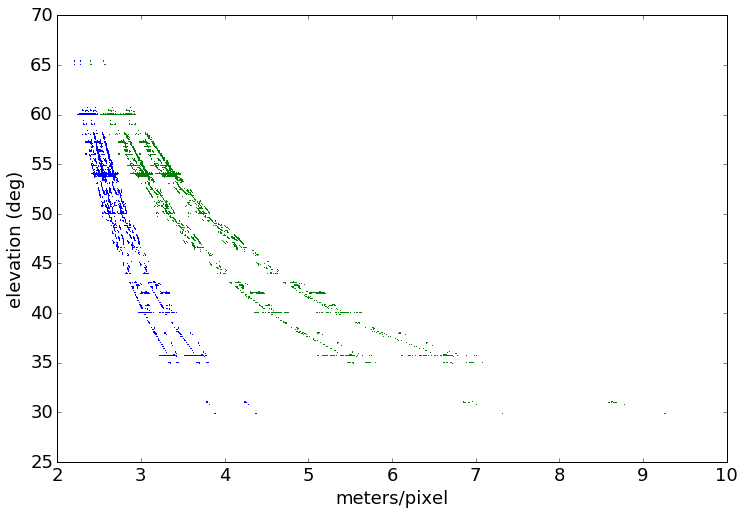

In [13]:
plot(dd.projection_conversion_x,(dd.el_guess)*180/np.pi,',')
plot(dd.projection_conversion,(dd.el_guess)*180/np.pi,',')
#xlim(2,10)
xlabel('meters/pixel')
ylabel('elevation (deg)')

In [14]:
dd.shape

(39127, 44)

In [15]:
import cloud_spec_fit
reload(cloud_spec_fit)

<module 'cloud_spec_fit' from '/home/gjones/cloud_spec_fit.pyc'>

In [16]:
np.median(dd.el_guess)

0.94225564260389105

In [17]:
ds = dd[np.abs(dd.el_guess-0.942) < 0.01]
np.median(ds.projection_conversion), np.median(ds.projection_conversion_x)

(3.1170835669226555, 2.5529441041868801)

In [18]:
def calc_spec_for_row(row):
    img = loading.get_image_array_from_filename(rawpath,row.which,row.filename,
                                                apply_flat_field_correction=True,adjust_flat_field=False)
    xffts = np.abs(np.fft.rfft((img*np.hamming(1024)[:,None]/np.hamming(1024).sum()),axis=0))**2
    xpsds = xffts.reshape((xffts.shape[0],6,-1)).mean(2)
    yffts = np.abs(np.fft.rfft((img*np.hamming(1536)[None,:]/np.hamming(1536).sum()),axis=1))**2
    #xffts = np.abs(np.fft.rfft((img[:,:1024]*np.hamming(1024)[None,:]/np.hamming(1024).sum()),axis=1))**2
    ypsds = yffts.reshape((4,-1,yffts.shape[1])).mean(1).T*1.5
    ky = (np.arange(ypsds.shape[0])  # cycles/image
          * (1/1536.0) # image/pixels
          * (1/row.projection_conversion) # pixels / meter
          * (1000.)) # meters / km  # final units are cycles/km
    kx = (np.arange(xpsds.shape[0])
          * (1/1024.) # image/pixels
          * (1/row.projection_conversion_x) # pixels/meter
          * (1000.)) # meters /km # final units are cycles/km
    try:
        maxx = np.flatnonzero(kx>100)[0]
        maxy = np.flatnonzero(ky>100)[0]
    except IndexError:
        maxx = -2
        maxy = -2
    fits_y = cloud_spec_fit.fit_psds(ky[2:maxy],ypsds[2:maxy,:],direction='y')
    fits_x = cloud_spec_fit.fit_psds(kx[2:maxx],xpsds[2:maxx,:],direction='x')
    
    spec_dict = dict(xpsds=[xpsds],ypsds = [ypsds],kx=[kx],ky=[ky],which=[row.which],filename=[row.filename],
                           avg = [img.mean(0,dtype='float64')], rms = [img.std(0)], avg0 = [img.mean(dtype='float64')],
                           rms0 = [img.std()])
    spec_dict.update(fits_x)
    spec_dict.update(fits_y)
    spec_row = pd.DataFrame(spec_dict,index=[0])
    return spec_row

In [19]:
pp = joblib.Parallel(n_jobs=30,verbose=5)

In [22]:
subset = xsc_df.iloc[::200]

In [23]:
subset.shape

(207, 44)

In [48]:
rows = pp(joblib.delayed(calc_spec_for_row)(row) for (k,row) in xsc_df.iterrows())

[Parallel(n_jobs=30)]: Done   1 out of 2294 | elapsed:    2.6s remaining: 97.6min
[Parallel(n_jobs=30)]: Done 8252 out of 41262 | elapsed: 45.9min remaining: 183.5min
[Parallel(n_jobs=30)]: Done 16505 out of 41262 | elapsed: 86.2min remaining: 129.3min
[Parallel(n_jobs=30)]: Done 24758 out of 41262 | elapsed: 129.1min remaining: 86.1min
[Parallel(n_jobs=30)]: Done 33011 out of 41262 | elapsed: 169.7min remaining: 42.4min
[Parallel(n_jobs=30)]: Done 41262 out of 41262 | elapsed: 210.3min finished


In [49]:
spec_df = pd.concat(rows)

In [50]:
spec_df = spec_df.reset_index()

In [51]:
del spec_df['index']

In [52]:
list(spec_df.columns)

['avg',
 'avg0',
 'filename',
 'kx',
 'ky',
 'rms',
 'rms0',
 'which',
 'x_segment_powlaw_nfev',
 'x_segment_powlaw_red_exp',
 'x_segment_powlaw_red_exp_err',
 'x_segment_powlaw_red_scale',
 'x_segment_powlaw_red_scale_err',
 'x_segment_powlaw_residual',
 'x_segment_powlaw_white_noise',
 'x_segment_powlaw_white_noise_err',
 'x_segment_roll_nfev',
 'x_segment_roll_red_exp',
 'x_segment_roll_red_exp_err',
 'x_segment_roll_red_scale',
 'x_segment_roll_red_scale_err',
 'x_segment_roll_residual',
 'x_segment_roll_roll_exp',
 'x_segment_roll_roll_exp_err',
 'x_segment_roll_roll_fc',
 'x_segment_roll_roll_fc_err',
 'x_segment_roll_white_noise',
 'x_segment_roll_white_noise_err',
 'x_whole_image_powlaw_nfev',
 'x_whole_image_powlaw_red_exp',
 'x_whole_image_powlaw_red_exp_err',
 'x_whole_image_powlaw_red_scale',
 'x_whole_image_powlaw_red_scale_err',
 'x_whole_image_powlaw_residual',
 'x_whole_image_powlaw_white_noise',
 'x_whole_image_powlaw_white_noise_err',
 'x_whole_image_roll_nfev',
 'x_w

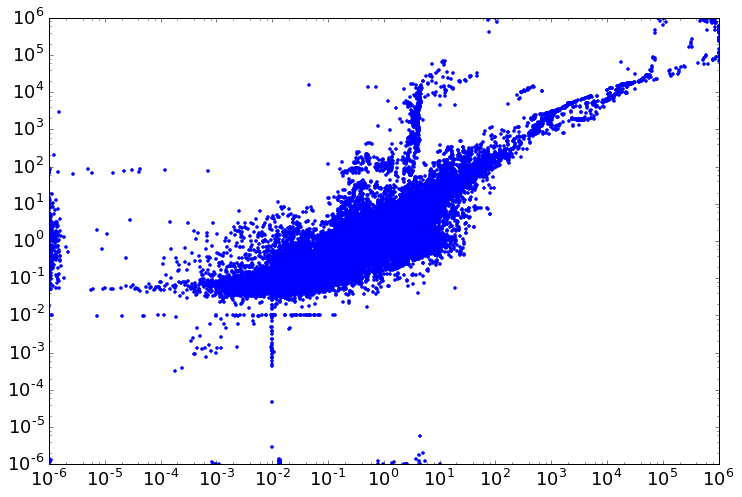

In [53]:
loglog(spec_df.y_whole_image_powlaw_red_scale,spec_df.x_whole_image_powlaw_red_scale,'.')

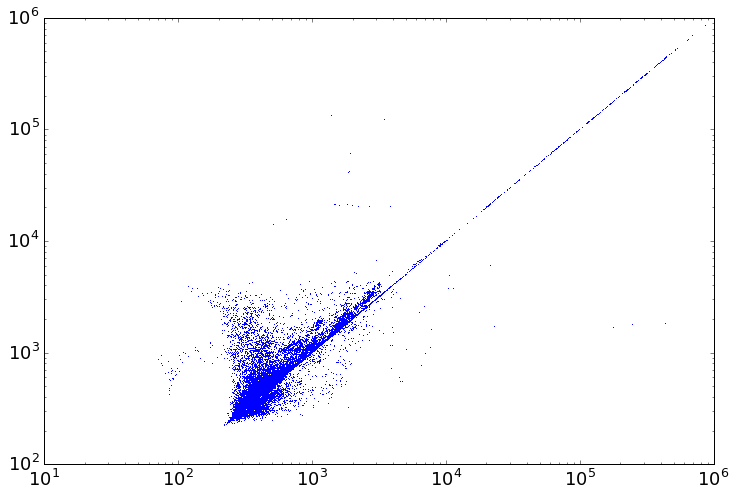

In [54]:
loglog(spec_df.y_whole_image_roll_residual,spec_df.y_whole_image_powlaw_residual,',')

In [19]:
sdf.y_whole_image_roll_roll_fc.shape

(41646,)

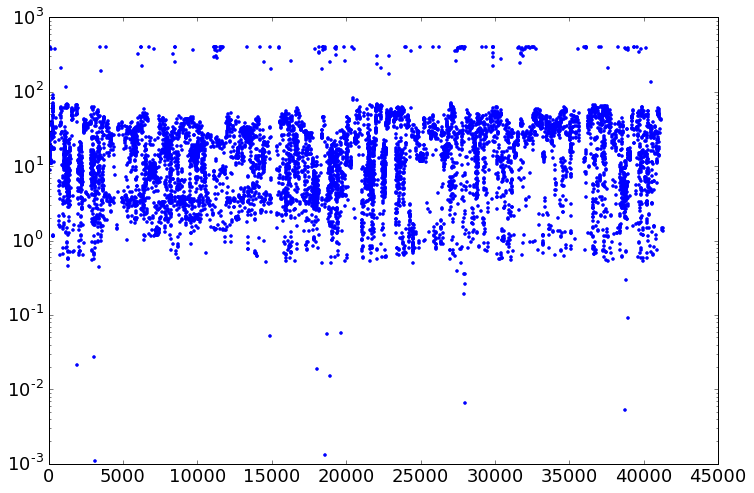

In [55]:
dd = spec_df[(spec_df.y_whole_image_roll_residual < spec_df.y_whole_image_powlaw_residual/1.1)]
semilogy(dd.index,dd.y_whole_image_roll_roll_fc,'.')

In [32]:
def plot_fits(row,index,do_emcee=False):
    if False:
        fig,axs = plt.subplots(1,6,figsize=(18,6))
        for k in range(6):
            ax = axs.flatten()[k]
            x = row.ky[2:-2]
            ax.loglog(x,row.ypsds[2:-2,k])
            pl = cloud_spec_fit.power_law(x,row.y_segment_powlaw_red_scale[k],row.y_segment_powlaw_red_exp[k]) + row.y_segment_powlaw_white_noise[k]
            ax.loglog(x,pl,lw=2)
            rolloff = cloud_spec_fit.full_model(x,red_scale = row.y_segment_roll_red_scale[k],
                                               red_exp = row.y_segment_roll_red_exp[k],
                                               roll_fc = row.y_segment_roll_roll_fc[k],
                                               roll_exp = row.y_segment_roll_roll_exp[k],
                                               white_noise=row.y_segment_roll_white_noise[k])
            ax.loglog(x,rolloff,'--',lw=2)
    fig,axs = plt.subplots(2,1,figsize=(12,12))
    ax = axs[1]
    x = row.ky[2:-2]
    ax.loglog(x,row.ypsds[2:-2,:].mean(1),'k',lw=2)
    ax.loglog(row.kx[2:-2],row.xpsds[2:-2,:].mean(1),'r',lw=2)
#    pl = cloud_spec_fit.power_law(x,row.y_whole_image_powlaw_red_scale,row.y_whole_image_powlaw_red_exp) + row.y_whole_image_powlaw_white_noise
#    ax.loglog(x,pl,':',lw=2)
    rolloff = cloud_spec_fit.full_model(x,red_scale = row.y_whole_image_roll_red_scale,
                                       red_exp = row.y_whole_image_roll_red_exp,
                                       roll_fc = row.y_whole_image_roll_roll_fc,
                                       roll_exp = row.y_whole_image_roll_roll_exp,
                                       white_noise=row.y_whole_image_roll_white_noise)
    ax.loglog(x,rolloff,color='r',lw=1.2)
    ax.loglog(x,row.ypsds[2:-2,:].mean(1)-row.y_whole_image_roll_white_noise)
    rolloff_nn = cloud_spec_fit.full_model(x,red_scale = row.y_whole_image_roll_red_scale,
                                       red_exp = row.y_whole_image_roll_red_exp,
                                       roll_fc = row.y_whole_image_roll_roll_fc,
                                       roll_exp = row.y_whole_image_roll_roll_exp,
                                       white_noise=0)
    ax.loglog(x,rolloff_nn,'--',lw=2)
    
    ax.loglog(x,row.y_whole_image_roll_red_scale*x**(row.y_whole_image_roll_red_exp),':',lw=2)
    ax.text(1e2,row.y_whole_image_roll_red_scale*(1e2)**(row.y_whole_image_roll_red_exp),
           ('$k^{%.2f}$' % row.y_whole_image_roll_red_exp), size='x-large')
    ax.loglog(x,x**(-row.y_whole_image_roll_roll_exp+row.y_whole_image_roll_red_exp),':',lw=2)
    ax.text(2,(2.)**(-row.y_whole_image_roll_roll_exp+row.y_whole_image_roll_red_exp),
           ('$k^{%.2f}$' % (row.y_whole_image_roll_red_exp-row.y_whole_image_roll_roll_exp)), size='x-large')
    
    
    if do_emcee:
        lmres,sampler,labels = cloud_spec_fit.emcee_fit_full(x,row.ypsds[2:-2,:].mean(1))
        for theta in sampler.flatchain[-100:]:
            ax.loglog(x,cloud_spec_fit.full_model_log(x,*theta)-10.**theta[-1],alpha=0.05,color='k')
        blah = corner.corner(sampler.flatchain,labels=labels)
    
    ax.axvline(row.y_whole_image_roll_roll_fc,linestyle='--')
    ax.text(row.y_whole_image_roll_roll_fc,2e-4,('$k_c=%.1f$/km' % row.y_whole_image_roll_roll_fc),size='x-large')
    ax.set_ylim(1e-4,1e2)
    ax.set_xlim(.3,300)
    ax.set_xlabel('wavenumber (cycles/km)')
    ax = axs[0]
    d = loading.get_image_array_from_filename(rawpath,row.which,row.filename,apply_flat_field_correction=True)
    d = leveling.level(d)
    ax.imshow(d,cmap=cm.gray,aspect='auto',origin='lower')
    ax.set_title('El:%.1f$^{\circ}$ px:%.2f py:%.2f kxr:(%.3f,%.3f) kyr:(%.3f,%.3f)' % (row.el_guess*180/np.pi,
                                                                                       row.projection_conversion_x,
                                                                                       row.projection_conversion,
                                                                                       row.kx[1],row.kx[-1],
                                                                                       row.ky[1],row.ky[-1],
                                                                                       ))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    fig.suptitle('%d: %s' % (index,row.filename))

$$P(k) = A k^{\alpha}+n_w$$

$$P(k) = \frac{A k^{\alpha}}{1+(k/k_c)^{\beta}}+n_w$$

In [46]:
import cloud_spec_fit
reload(cloud_spec_fit)
import corner

In [70]:
dd.shape

(25, 132)

In [56]:
mdf = pd.merge(spec_df,xsc_df,on=['which','filename'])

In [34]:
mdf.el_guess.max()*180/np.pi

60.005741128695796

In [57]:
subsel = mdf[(mdf.lat !=0) & (mdf.el_guess >0.5) &(mdf.alt>30000) 
             & (mdf.alt < 40000) & (mdf.dec_err < 0.02) & (mdf.el_guess < (55*np.pi/180.))
            & ~(mdf.rms0.isnull())]

In [58]:
subsel.shape

(32547, 132)

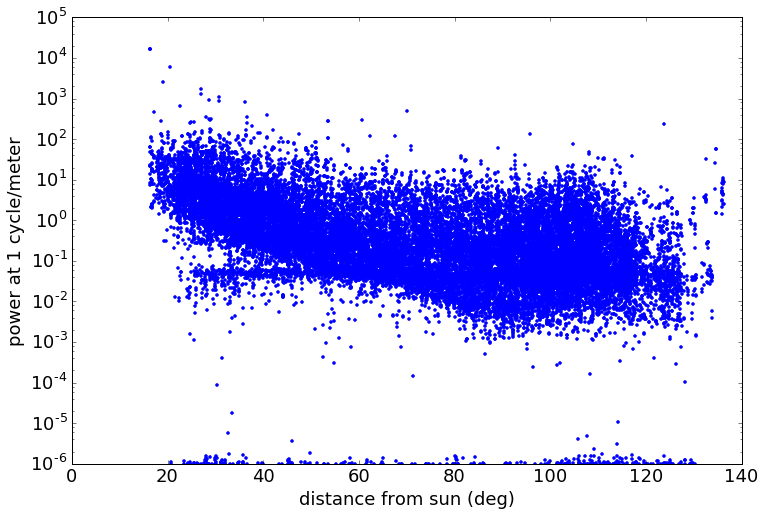

In [59]:
semilogy(subsel.distance_from_sun*180/np.pi, subsel.y_whole_image_roll_red_scale,'.')
xlabel('distance from sun (deg)')
ylabel('power at 1 cycle/meter')

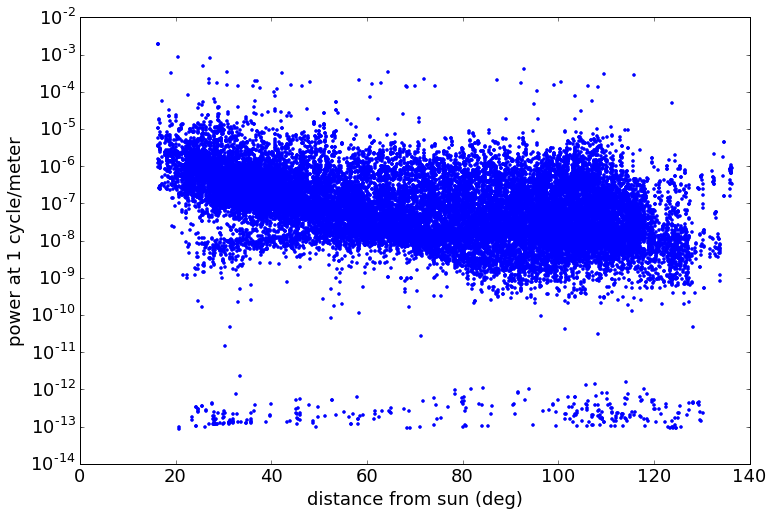

In [60]:
semilogy(subsel.distance_from_sun*180/np.pi, subsel.y_whole_image_roll_red_scale/subsel.avg0**2,'.')
xlabel('distance from sun (deg)')
ylabel('power at 1 cycle/meter')

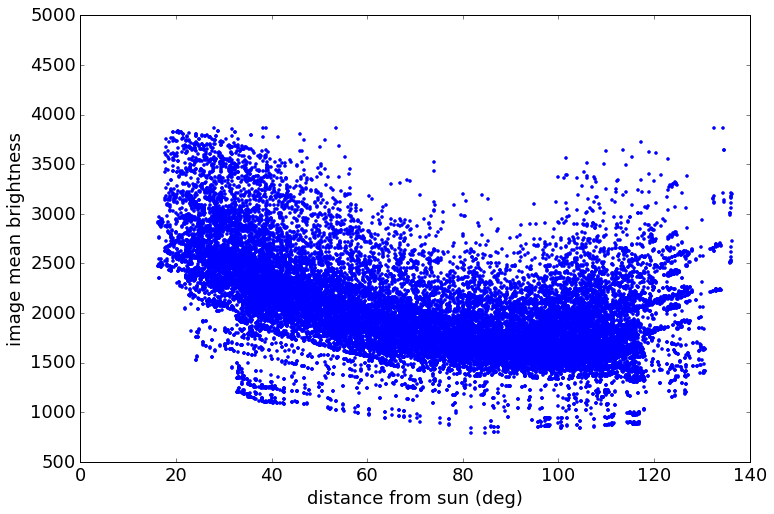

In [105]:
plot(subsel.distance_from_sun*180/np.pi, subsel.avg0,'.')
ylim(500,5e3)
xlabel('distance from sun (deg)')
ylabel('image mean brightness')

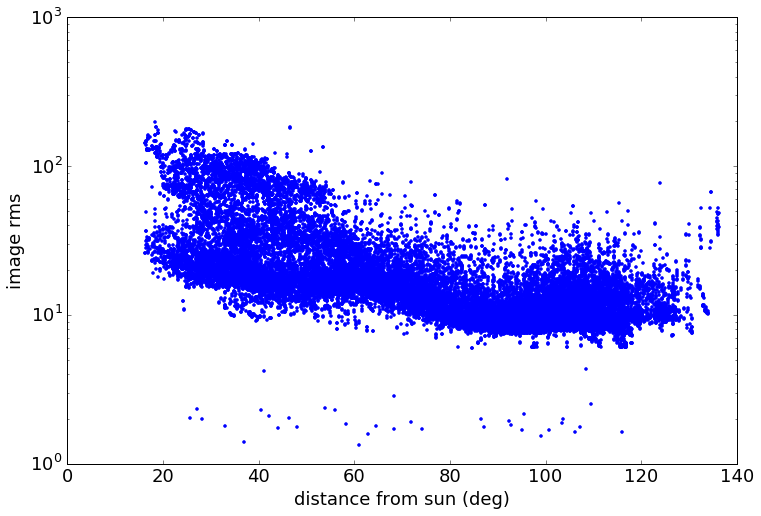

In [62]:
semilogy(subsel.distance_from_sun*180/np.pi, subsel.rms0,'.')
#ylim(500,5e3)
xlabel('distance from sun (deg)')
ylabel('image rms')

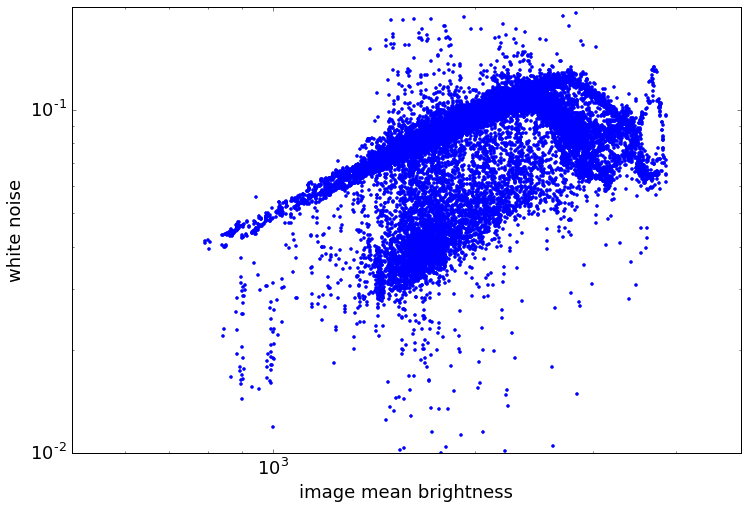

In [63]:
loglog(subsel.avg0,subsel.y_whole_image_roll_white_noise,'.')
xlim(500,5000)
ylim(1e-2,2e-1)
ylabel('white noise')
xlabel('image mean brightness')

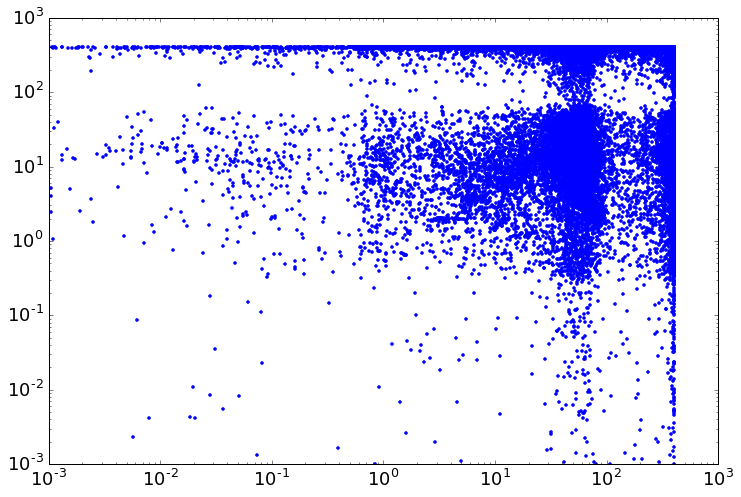

In [64]:
loglog(subsel.x_whole_image_roll_roll_fc,subsel.y_whole_image_roll_roll_fc,'.')

In [65]:
attrs = [x[2:] for x in subsel.columns if x.startswith('x_whole_') and not x.endswith('err')]

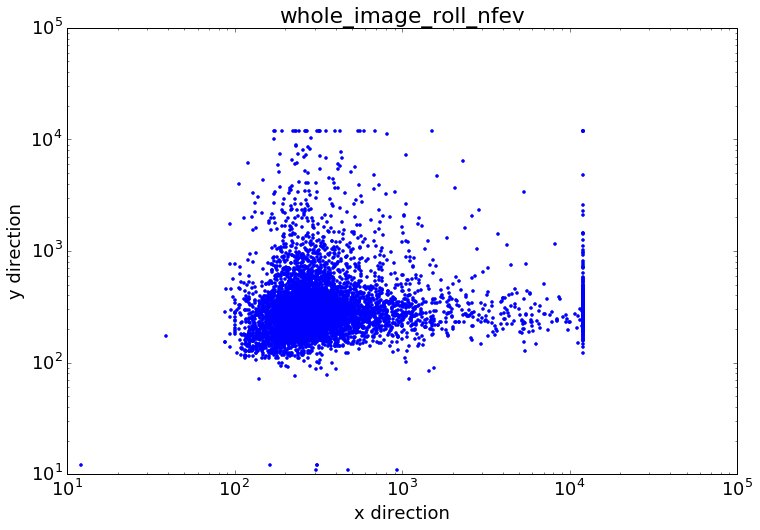

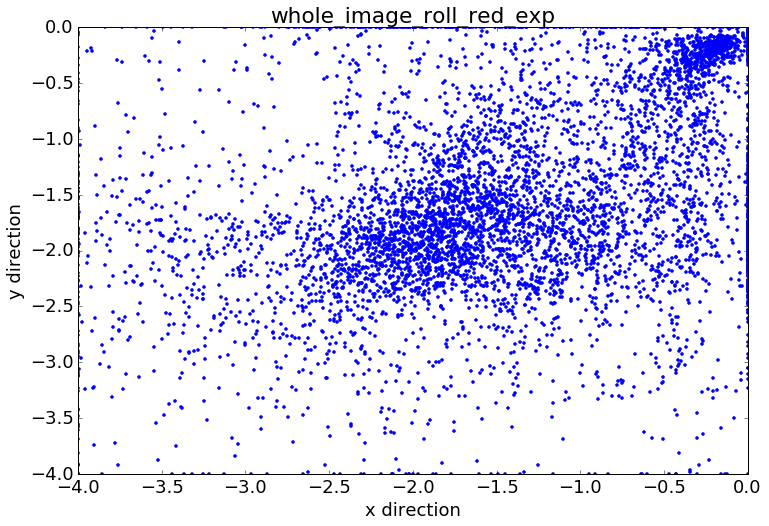

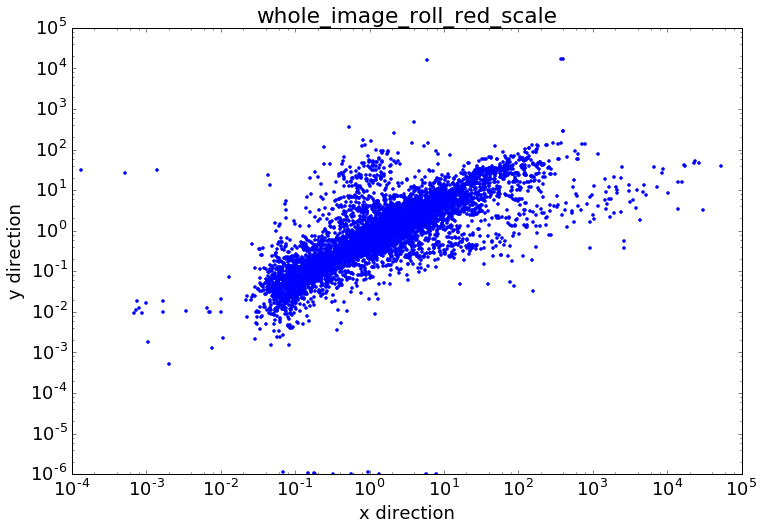

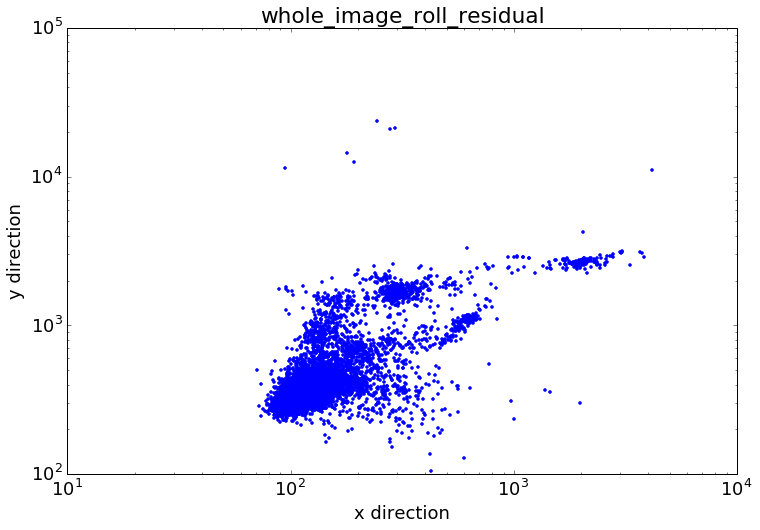

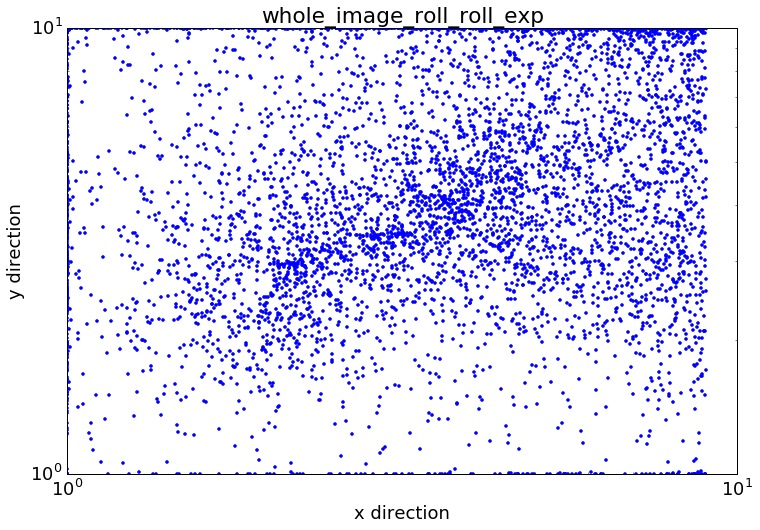

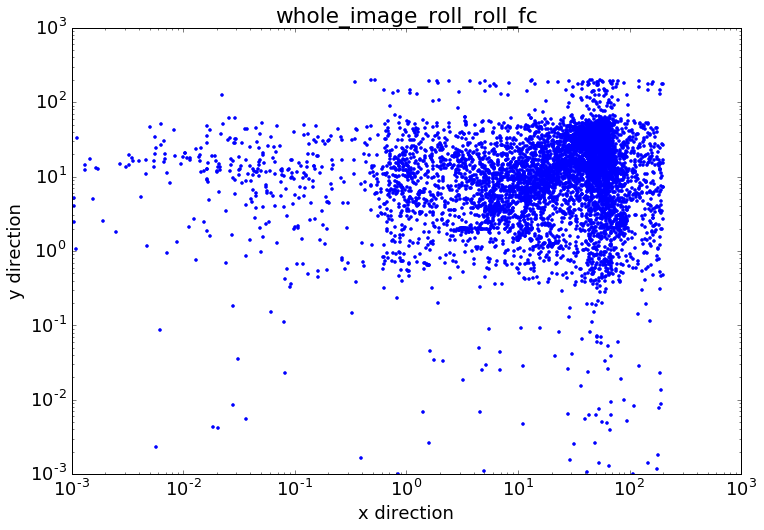

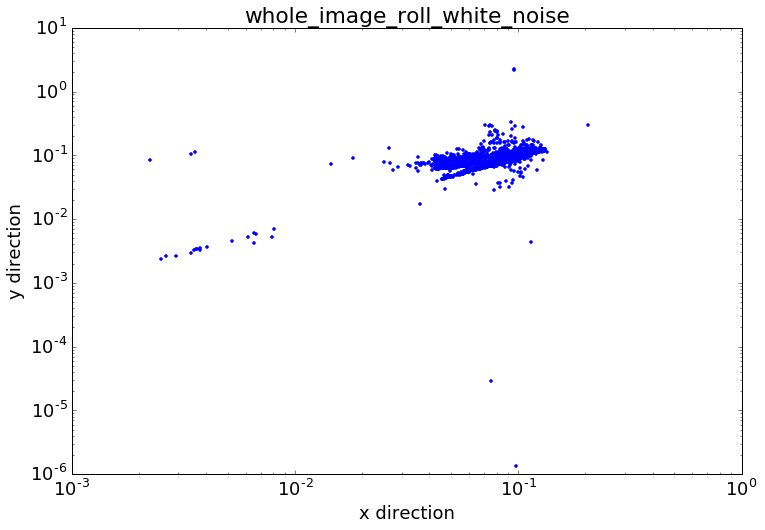

In [66]:
attrs = [x[2:] for x in subsel.columns if x.startswith('x_whole_image_roll') and not x.endswith('err')]
dd = subsel[(subsel.x_whole_image_roll_roll_fc < 200) &(subsel.y_whole_image_roll_roll_fc < 200)
           & (subsel.x_whole_image_roll_roll_exp < 9)]
for attr in attrs:
    figure()
    x = dd['x_'+attr]
    y = dd['y_'+attr]
    if np.all(x>0) and np.all(y>0):
        loglog(x,y,'.')
    else:
        plot(x,y,'.')
    title(attr)
    xlabel('x direction')
    ylabel('y direction')

(0.0001, 100)

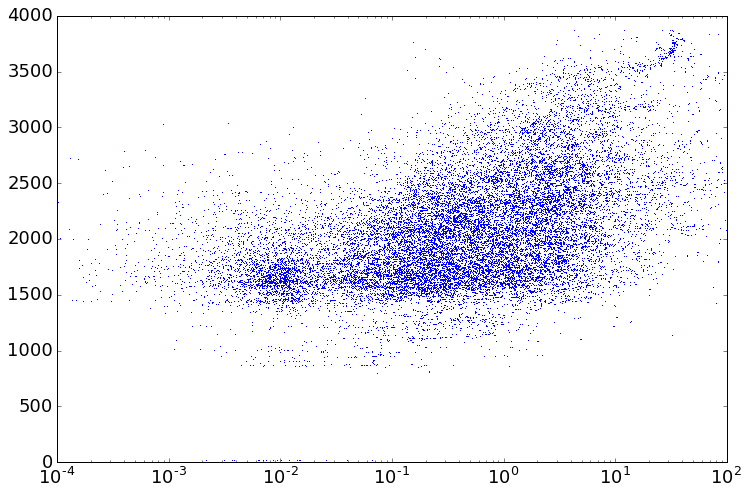

In [104]:
semilogx(subsel.y_whole_image_roll_red_scale-subsel.y_whole_image_roll_white_noise,subsel.avg0,',')
#loglog(dd.y_whole_image_roll_red_scale,dd.avg0,'.')
#ylim(600,6000)
xlim(1e-4,100)

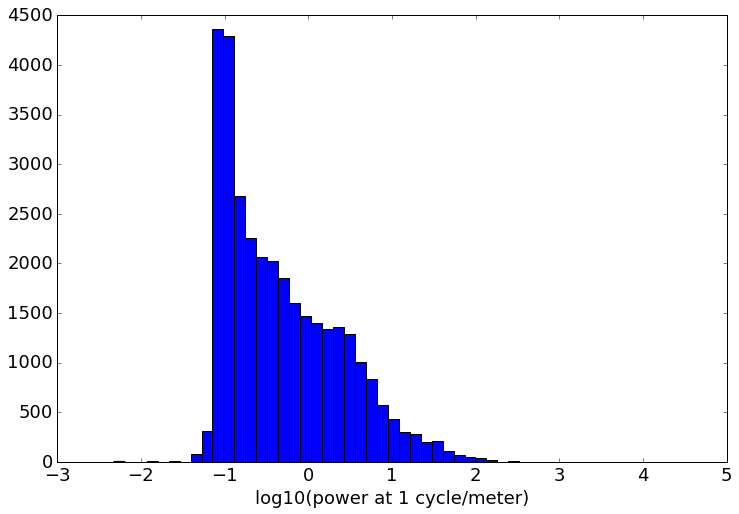

In [67]:
blah = hist(np.log10(np.array(subsel.y_whole_image_roll_white_noise+subsel.y_whole_image_roll_red_scale)),bins=50)
xlabel('log10(power at 1 cycle/meter)')

In [85]:
dd = subsel[(subsel.distance_from_sun > (60*np.pi/180.)) & (subsel.y_whole_image_roll_roll_exp < 9)
           & (subsel.y_whole_image_roll_red_exp > -3.8) & (subsel.y_whole_image_roll_roll_fc>1) & ~(subsel.rms0.isnull())
           #& (subsel.y_whole_image_roll_roll_fc<200)
           ]#& (subsel.y_whole_image_roll_red_scale>1)]

In [86]:
dd.shape

(9798, 132)

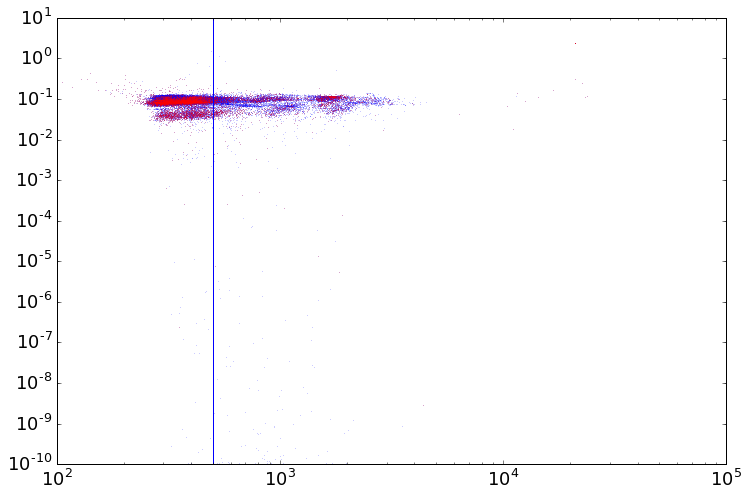

In [87]:
loglog(subsel.y_whole_image_roll_residual,subsel.y_whole_image_roll_white_noise,',',alpha=0.2)
loglog(dd.y_whole_image_roll_residual,dd.y_whole_image_roll_white_noise,'r,',alpha=0.2)

gca().axvline(10**2.7)

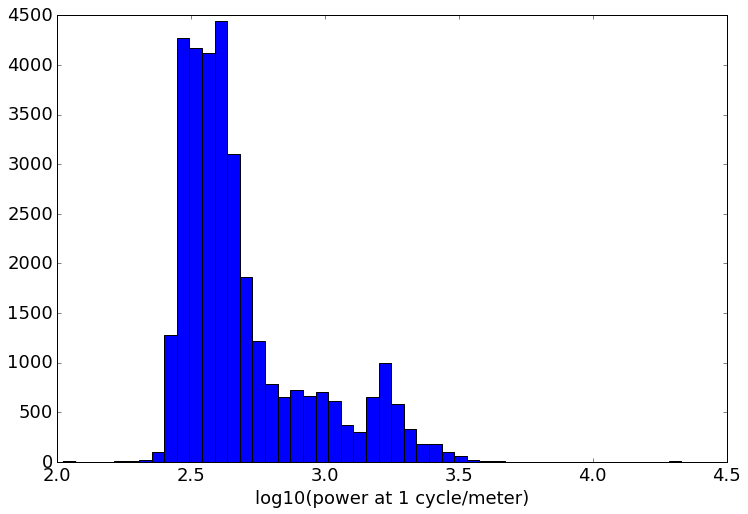

In [68]:
blah = hist(np.log10(np.array(subsel.y_whole_image_roll_residual)),bins=50)
xlabel('log10(power at 1 cycle/meter)')

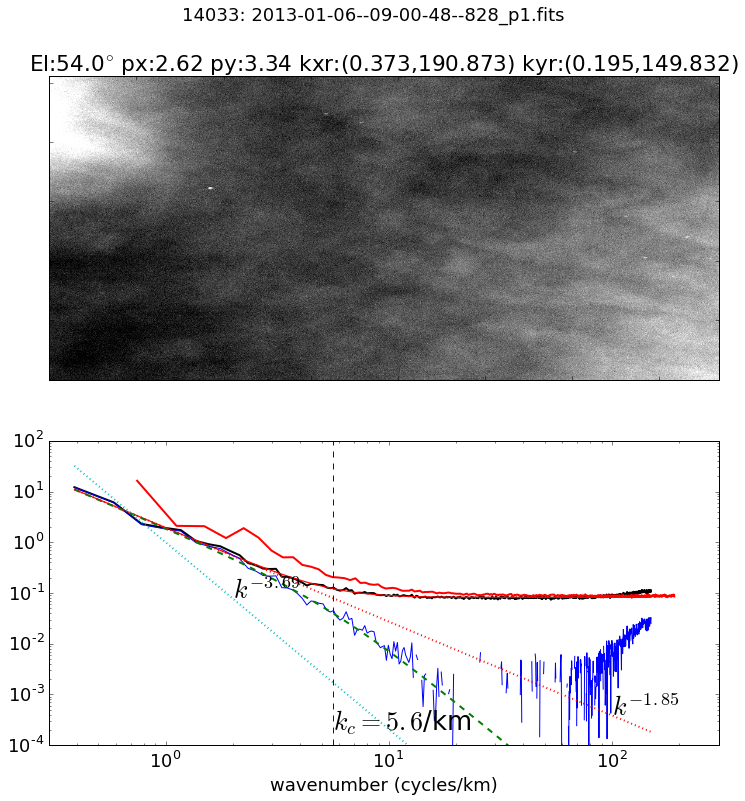

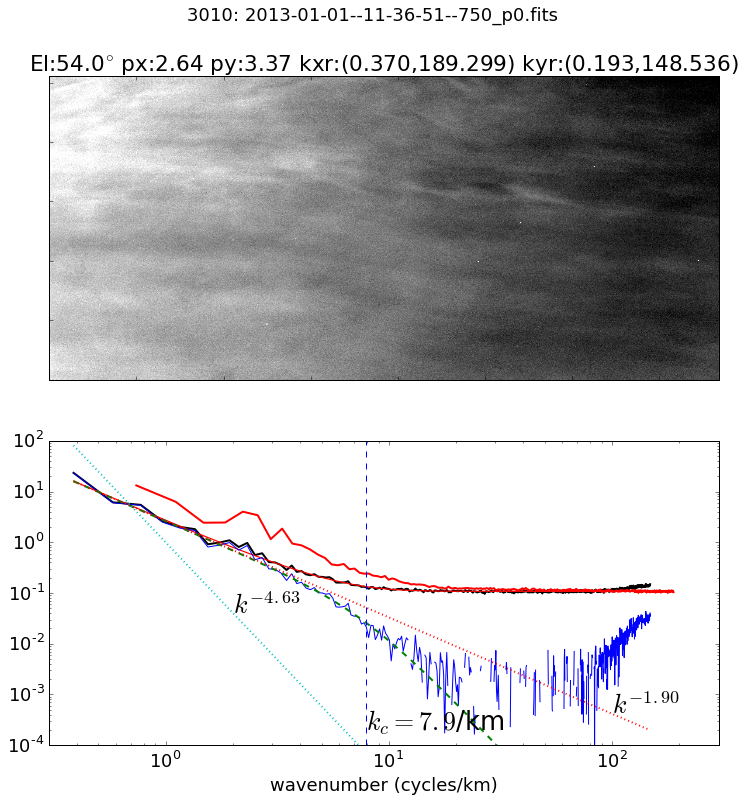

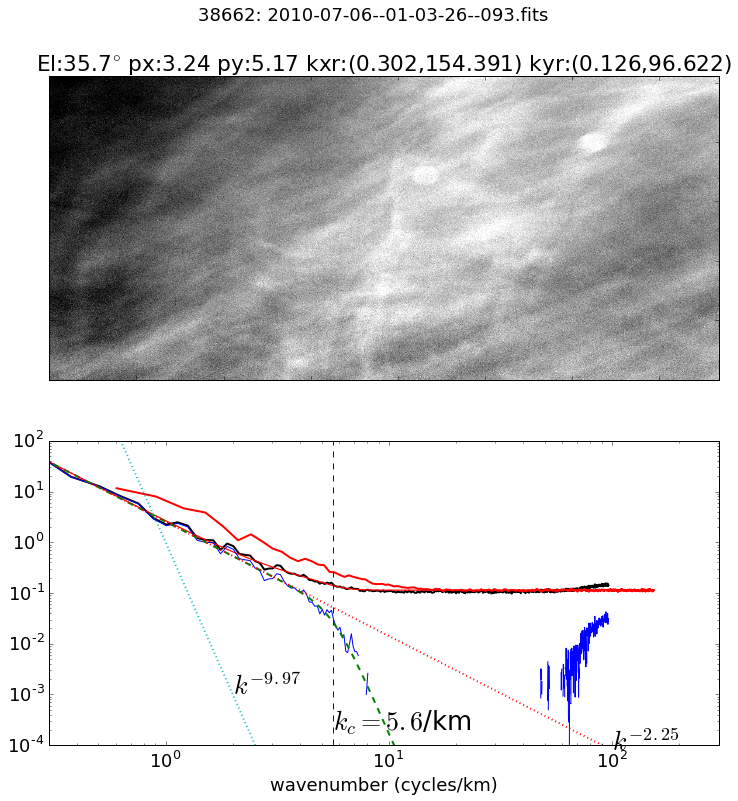

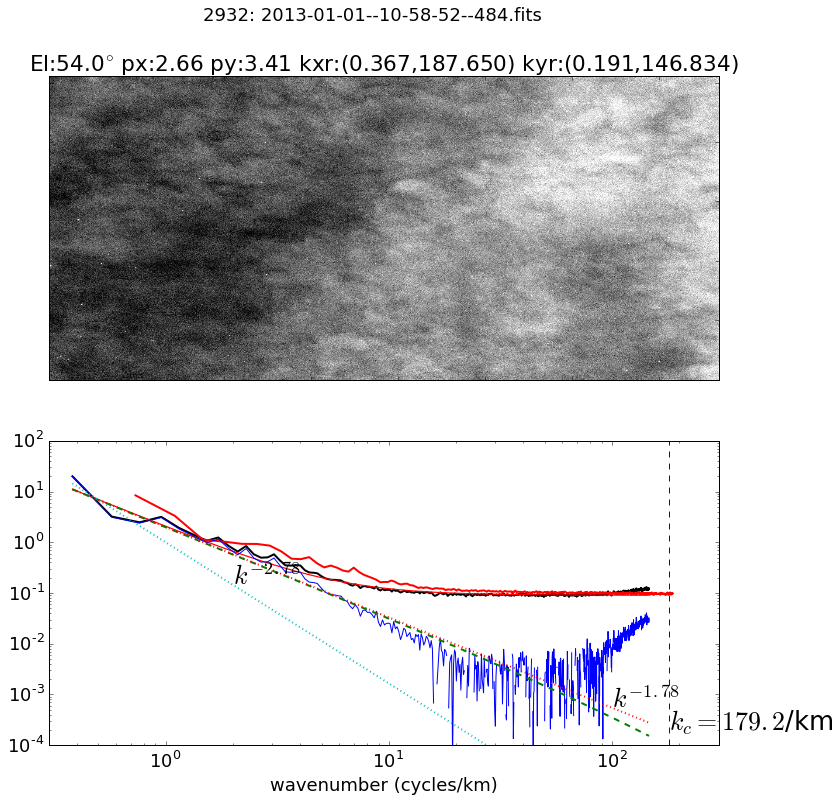

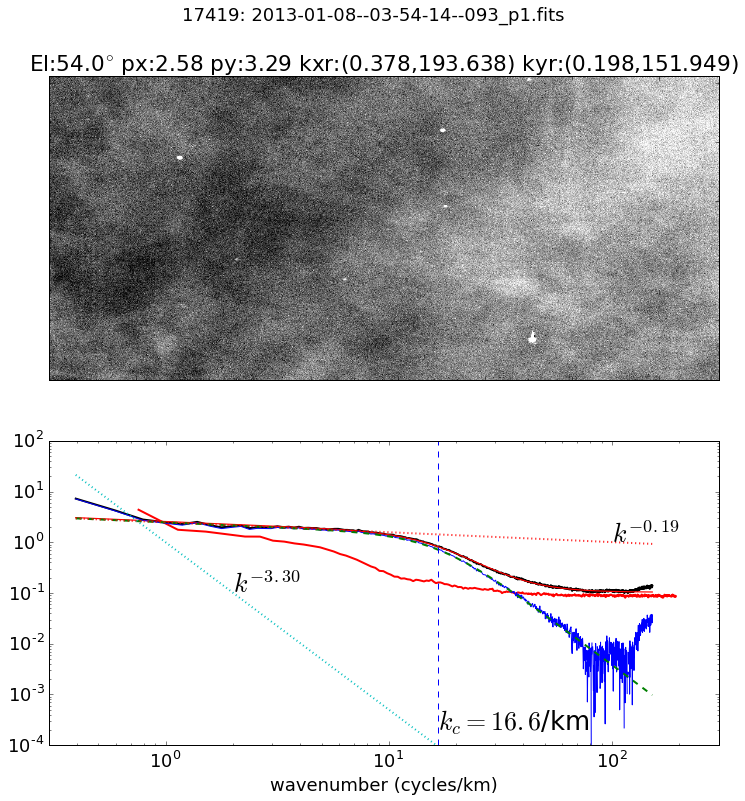

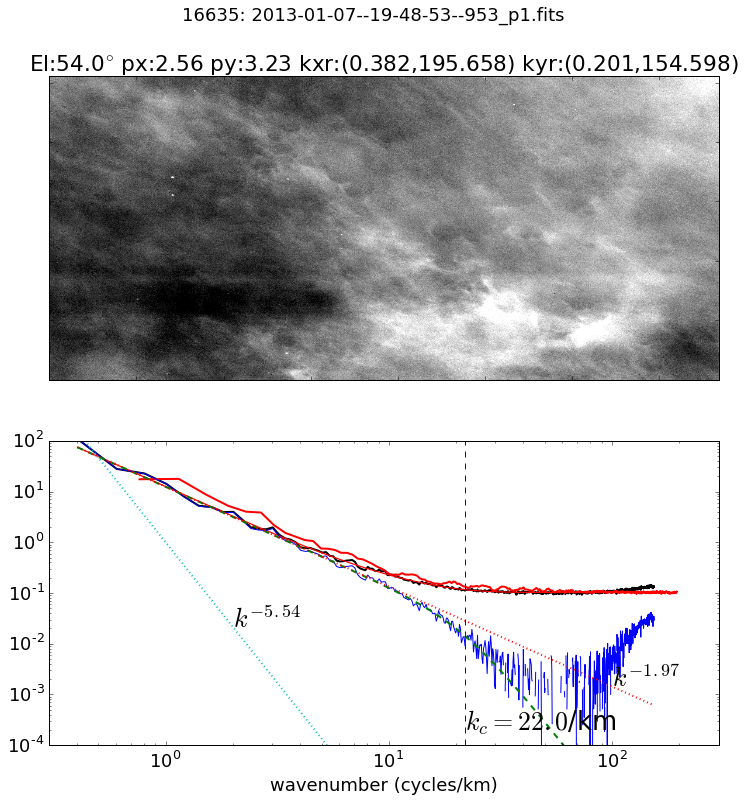

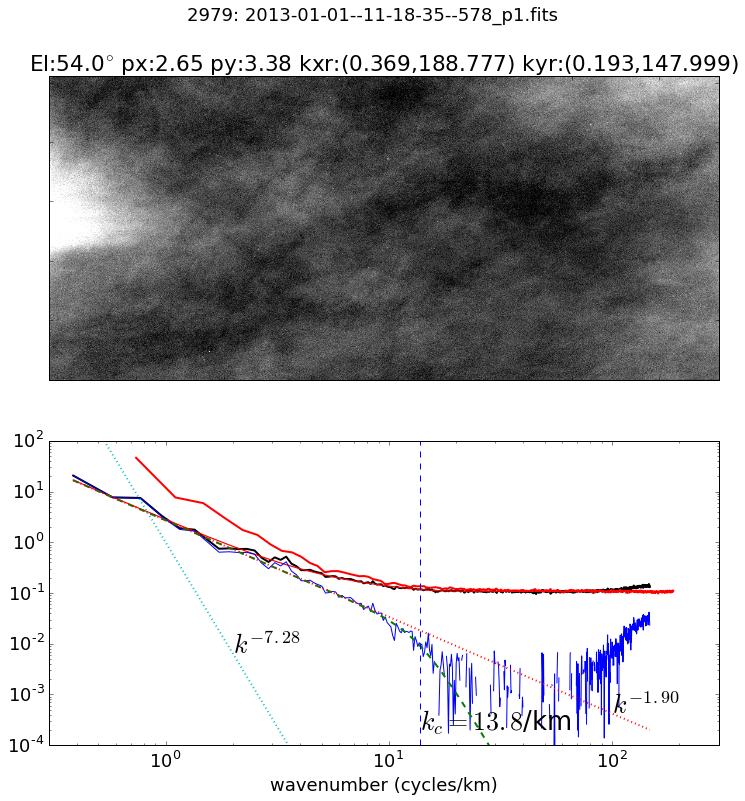

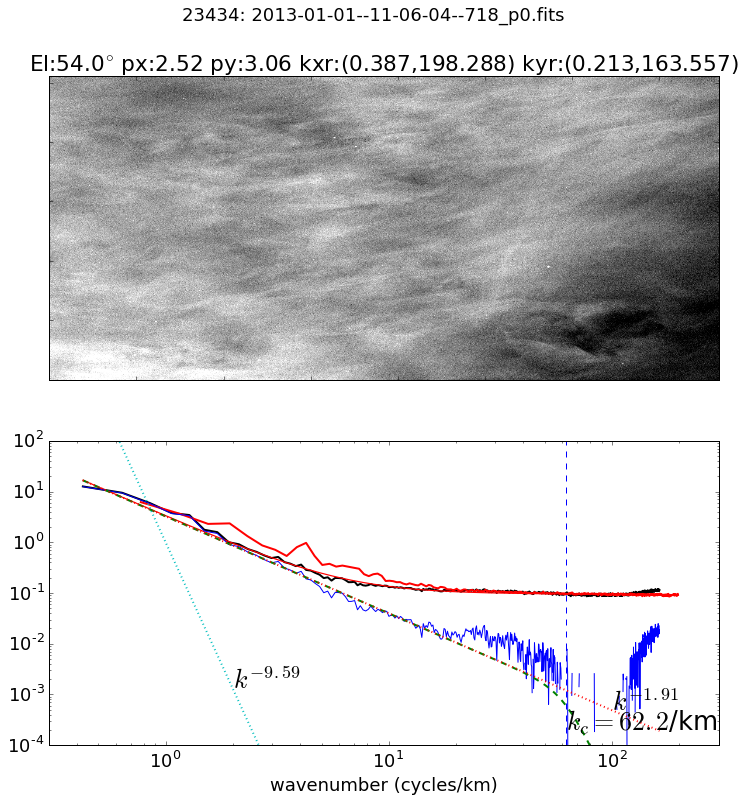

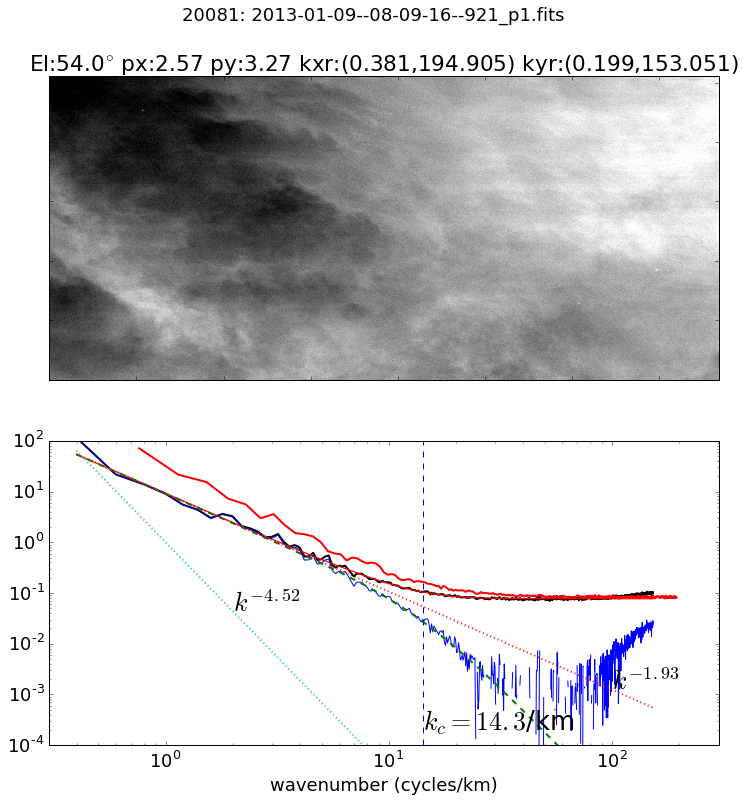

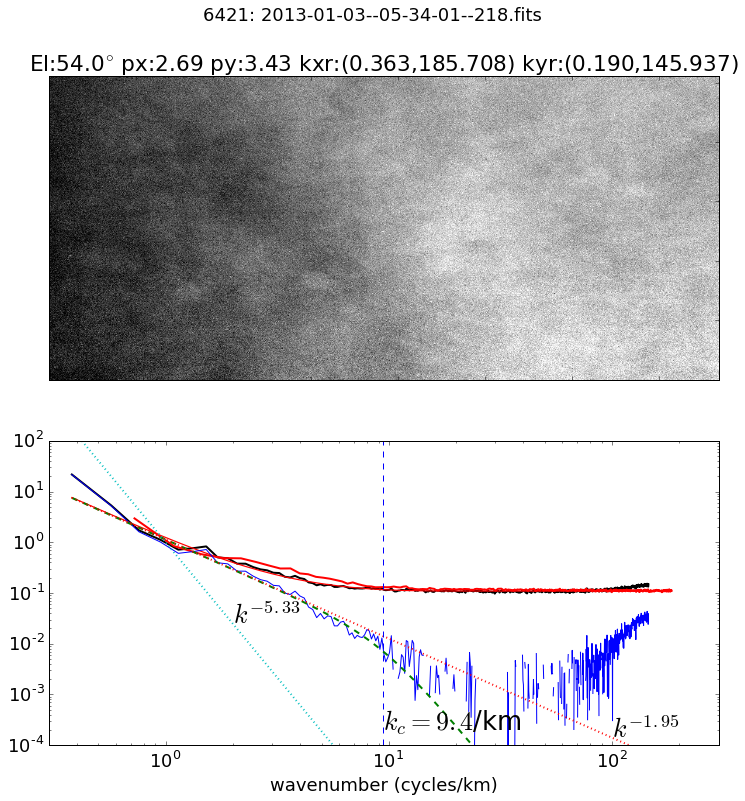

In [89]:
#dd = subsel[(subsel.y_whole_image_roll_roll_fc<20) & (subsel.y_whole_image_roll_residual < subsel.y_whole_image_powlaw_residual/1.2)]
dd = subsel[(subsel.distance_from_sun > (60*np.pi/180.)) & (subsel.y_whole_image_roll_roll_exp < 9)
           & (subsel.y_whole_image_roll_red_exp > -3.8) & (subsel.y_whole_image_roll_roll_fc>1) & ~(subsel.rms0.isnull())
           & (subsel.y_whole_image_roll_roll_fc<200)
           & (subsel.y_whole_image_roll_red_scale>1)]
random.seed(123)
idxs = random.choice(dd.index,size=(10,),replace=False)
for k in idxs:
#    if random.random()<1.25:
        plot_fits(dd.ix[k],k)
        
#        savefig(('/home/gjones/cloud_plots/%s.jpg' % row.filename), bbox_inches='tight')

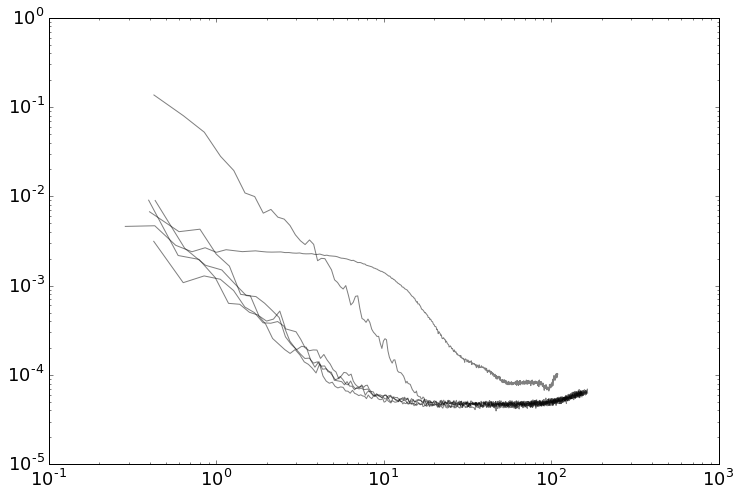

In [44]:
#dd = subsel[(subsel.y_whole_image_roll_roll_fc<20) & (subsel.y_whole_image_roll_residual < subsel.y_whole_image_powlaw_residual/1.2)]
dd = subsel[(subsel.distance_from_sun > (60*np.pi/180.)) & (subsel.y_whole_image_roll_roll_exp < 9)
           & (subsel.y_whole_image_roll_red_exp > -3.8) & (subsel.y_whole_image_roll_roll_fc>1) & ~(subsel.rms0.isnull())
           & (subsel.y_whole_image_roll_roll_fc<200)
           & (subsel.y_whole_image_roll_red_scale>1)]
random.seed(123)
for k,row in dd.iterrows():
    loglog(row.ky[2:-2],row.ypsds.mean(1)[2:-2]/row.avg0, 'k', alpha=0.5)
        
#        savefig(('/home/gjones/cloud_plots/%s.jpg' % row.filename), bbox_inches='tight')

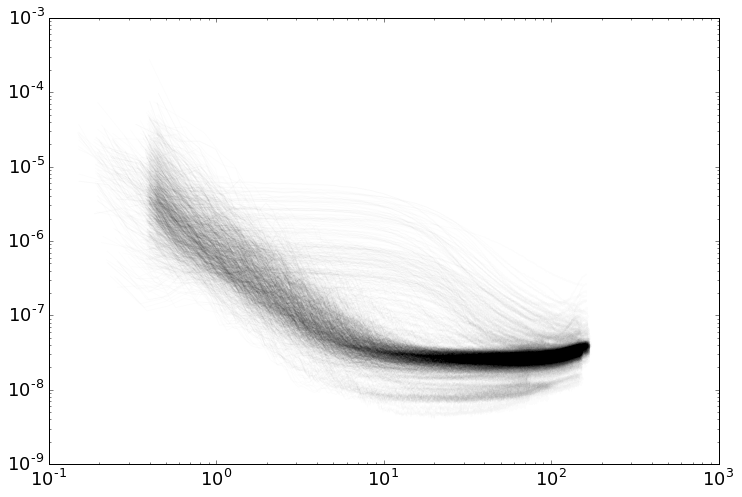

In [110]:
#dd = subsel[(subsel.y_whole_image_roll_roll_fc<20) & (subsel.y_whole_image_roll_residual < subsel.y_whole_image_powlaw_residual/1.2)]
dd = subsel[(subsel.distance_from_sun > (60*np.pi/180.)) & (subsel.y_whole_image_roll_roll_exp < 9)
           & (subsel.y_whole_image_roll_red_exp > -3.8) & (subsel.y_whole_image_roll_roll_fc>1) & ~(subsel.rms0.isnull())
           & (subsel.y_whole_image_roll_roll_fc<200)
           & (subsel.y_whole_image_roll_red_scale>1)]
random.seed(123)

for k,row in dd.iterrows():
    loglog(row.ky[2:-2],row.ypsds.mean(1)[2:-2]/row.avg0**2, 'k', alpha=0.01)
        
#        savefig(('/home/gjones/cloud_plots/%s.jpg' % row.filename), bbox_inches='tight')

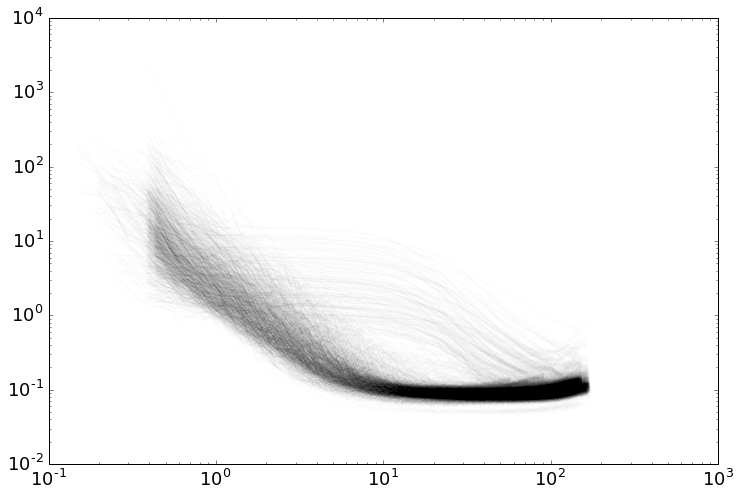

In [117]:
#dd = subsel[(subsel.y_whole_image_roll_roll_fc<20) & (subsel.y_whole_image_roll_residual < subsel.y_whole_image_powlaw_residual/1.2)]
dd = subsel[(subsel.distance_from_sun > (60*np.pi/180.)) & (subsel.y_whole_image_roll_roll_exp < 9)
           & (subsel.y_whole_image_roll_red_exp > -3.8) & (subsel.y_whole_image_roll_roll_fc>1) & ~(subsel.rms0.isnull())
           & (subsel.y_whole_image_roll_roll_fc<200)
           & (subsel.y_whole_image_roll_red_scale>1)]
random.seed(123)

for k,row in dd.iterrows():
    loglog(row.ky[2:-2],row.ypsds.mean(1)[2:-2], 'k', alpha=0.01)
        
#        savefig(('/home/gjones/cloud_plots/%s.jpg' % row.filename), bbox_inches='tight')

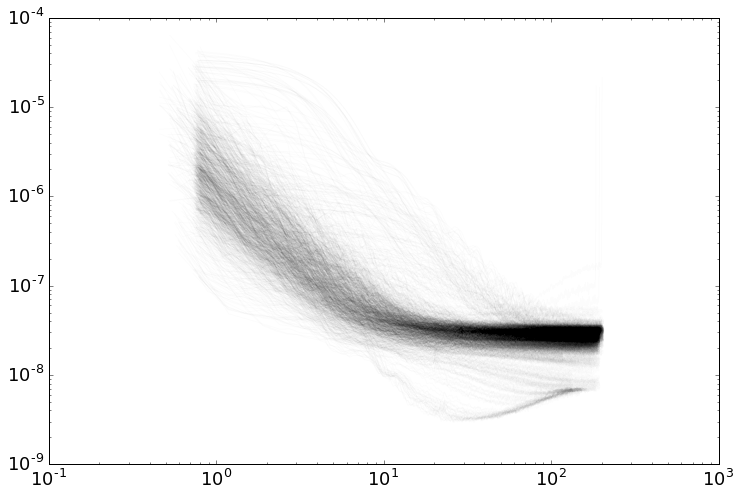

In [126]:
#dd = subsel[(subsel.y_whole_image_roll_roll_fc<20) & (subsel.y_whole_image_roll_residual < subsel.y_whole_image_powlaw_residual/1.2)]
dd = subsel[(subsel.distance_from_sun > (60*np.pi/180.)) & (subsel.y_whole_image_roll_roll_exp < 9)
           & (subsel.y_whole_image_roll_red_exp > -3.8) & (subsel.y_whole_image_roll_roll_fc>1) & ~(subsel.rms0.isnull())
           & (subsel.y_whole_image_roll_roll_fc<200)
           & (subsel.y_whole_image_roll_red_scale>1)]
random.seed(123)

for k,row in dd.iterrows():
    loglog(row.kx[2:-2],row.xpsds.mean(1)[2:-2]/row.avg0**2, 'k', alpha=0.01)
        
#        savefig(('/home/gjones/cloud_plots/%s.jpg' % row.filename), bbox_inches='tight')

In [ ]:
epsilon*n^3

(1000, 4000)

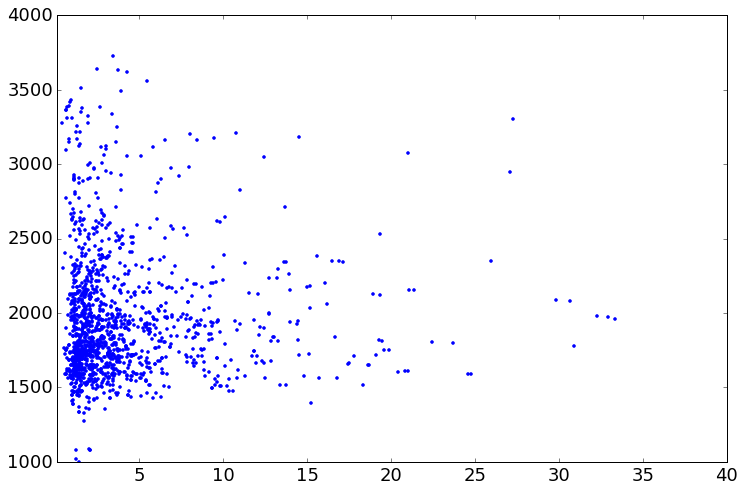

In [120]:
plot(dd.y_whole_image_powlaw_red_scale,dd.avg0,'.')
xlim(0.1,40)
ylim(1000,4000)

(0.1, 40)

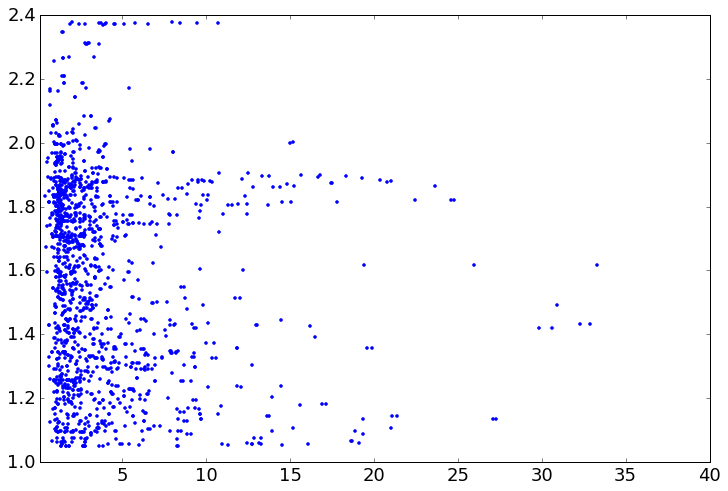

In [123]:
plot(dd.y_whole_image_powlaw_red_scale,dd.distance_from_sun,'.')
xlim(0.1,40)
#ylim(1000,4000)

(1000, 4000)

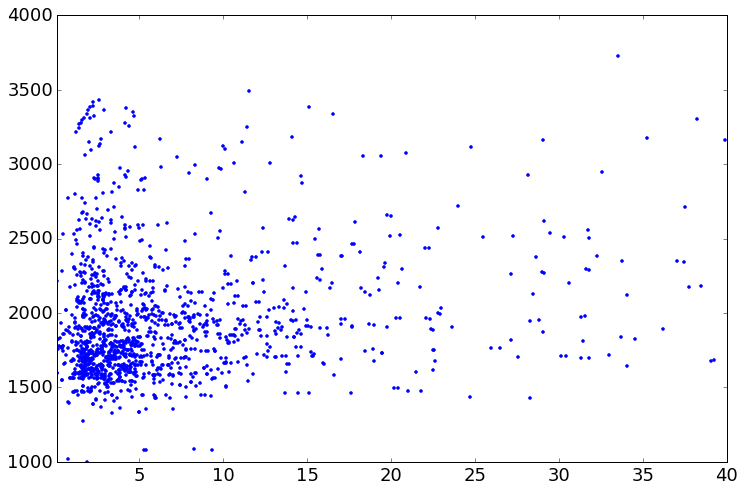

In [121]:
plot(dd.x_whole_image_powlaw_red_scale,dd.avg0,'.')
xlim(0.1,40)
ylim(1000,4000)

In [108]:
dd.shape

(1506, 132)

In [30]:
np.savez('/home/gjones/2016-01-29-xsc-merged-datafame.npz',df = mdf.to_records())

In [73]:
sdf.shape

(41646, 52)

(0.001, 100.0)

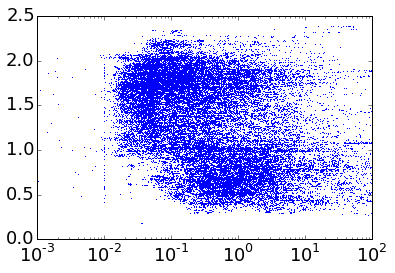

In [24]:
semilogx(mdf.y_whole_image_roll_red_scale,mdf.distance_from_sun,',')
xlim(1e-3,1e2)

In [147]:
mdf.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
            ...
            890, 891, 892, 893, 894, 895, 896, 897, 898, 899],
           dtype='int64', length=900)

In [98]:
mdf.shape

(40972, 94)

In [150]:
mdf.ypsds.iloc[890][2:-2,:].shape

(509, 6)

In [157]:
fits = cloud_spec_fit.fit_psds(mdf.ky.iloc[890][2:-2],mdf.ypsds.iloc[890][2:-2,:],direction='y')

In [158]:
fits

{'y_segment_powlaw_red_exp': [array([-1.74920229, -1.79940134, -1.43158547, -1.4439261 , -2.04098658,
         -1.42042774])],
 'y_segment_powlaw_red_exp_err': [array([ 0.02068482,  0.01622645,  0.02051106,  0.02148279,  0.01486597,
          0.02218273])],
 'y_segment_powlaw_red_scale': [array([  8.8763803 ,   9.53025082,   3.3029191 ,   4.07329047,
          15.05820005,   2.36140028])],
 'y_segment_powlaw_red_scale_err': [array([ 0.38053968,  0.30980668,  0.14175234,  0.19563971,  0.43429483,
          0.09908005])],
 'y_segment_powlaw_white_noise': [array([ 0.06399802,  0.06319031,  0.05964977,  0.0580119 ,  0.06194077,
          0.06102561])],
 'y_segment_powlaw_white_noise_err': [array([ 0.00057602,  0.00042777,  0.00067676,  0.00075581,  0.00031038,
          0.00052121])],
 'y_segment_roll_red_exp': [array([-1.18316485, -1.4549028 , -0.63184879, -1.44395448, -1.81781102,
         -1.4161308 ])],
 'y_segment_roll_red_exp_err': [array([ 0.06824196,  0.0448852 ,  0.06131177,  0.02

In [32]:
im = ims[1000]
d = loading.get_image_array_from_filename(rawpath,im.which,im.filename,
                                                apply_flat_field_correction=True,adjust_flat_field=False)

In [34]:
d.shape

(1024, 1536)

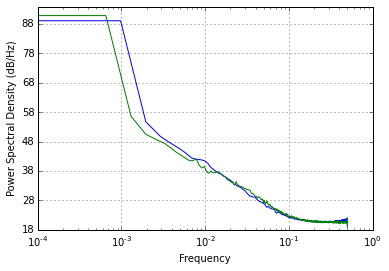

In [47]:
blah = psd(d.flatten(),NFFT=1024,Fs=1.0)
blah = psd(d.T.flatten(),NFFT=1536,Fs=1.0)
xscale('log')

In [35]:
d2 = d.reshape((4,256,1536))

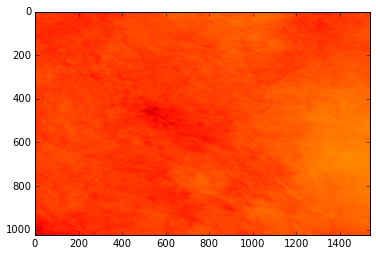

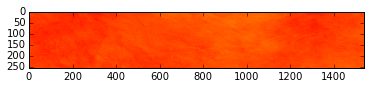

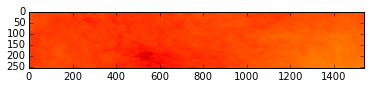

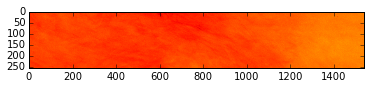

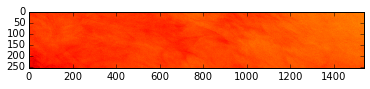

In [43]:
imshow(d/d.max())
clim(0,1)
for k in range(4):
    figure()
    imshow(d2[k]/(1.*d.max()))
    clim(0,1)

In [88]:
np.sqrt(3)

1.7320508075688772

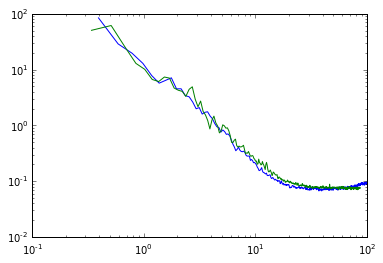

In [90]:
loglog(r1.kx.iloc[0][2:-2],r1.xpsds.iloc[0][2:-2].mean(1))
loglog(r1.ky.iloc[0][2:-2]/np.sqrt(3),r1.ypsds.iloc[0][2:-2].mean(1))


In [10]:
data = []
tic = time.time()
for im in ims[:10]:
    img = loading.get_image_array_from_filename(rawpath,im.which,im.filename,
                                                apply_flat_field_correction=True,adjust_flat_field=False)
    ffts = np.abs(np.fft.rfft((img),axis=0)/1024)**2
    psds = ffts.reshape((ffts.shape[0],6,-1)).mean(2)
    wffts = np.abs(np.fft.rfft((img*np.hamming(1024)[:,None]/np.hamming(1024).sum()),axis=0)/1024)**2
    wpsds = wffts.reshape((wffts.shape[0],6,-1)).mean(2)
    
    row = pd.DataFrame(dict(psds=[psds],wpsds = [wpsds],which=[im.which],filename=[im.filename],timestamp=[im.timestamp],is_at_float=[im.is_at_float],
                           avg = [img.mean(0,dtype='float64')], rms = [img.std(0)], avg0 = [img.mean(dtype='float64')],
                           rms0 = [img.std()]),index=[0])
    data.append(row)
    timeper = (time.time()-tic)/len(data)
    total = timeper*len(ims)
    finish = tic + total
    print "\rtime per",timeper,"total",(total/3600.),"finish at",time.ctime(finish),

time per 0.278588700294 total 3.22280694791 finish at Thu Oct 29 14:24:48 2015
